<a href="https://colab.research.google.com/github/guilimadev/Volleyball-Game-Win-Predictor/blob/main/Volleyball_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
import warnings

warnings.filterwarnings("ignore")

In [30]:
df_vnl = pd.read_csv('gdrive/My Drive/Colab Notebooks/csv/vnl_2021_preliminaryround_mens.csv',index_col=1)
df_vnl = df_vnl.drop('Unnamed: 0', axis=1)

df_pallavolo = pd.read_csv('gdrive/My Drive/Colab Notebooks/csv/Pallavolo_Teams_Stats.csv')
df_pallavolo = df_pallavolo.drop('Unnamed: 0', axis=1)
df_pallavolo['bloqueio'] = df_pallavolo['bloqueio'].str.replace(',','.')

In [31]:
df_vnl.index.names = ['id_jogo']


In [32]:
df_vnl = df_vnl.rename(columns={'qts sets': 'qtd sets'})
df_vnl.head()

,team home,total atq home,pontos ataques home,atq error home,% atq home,% rec home,bloqueio home,server error home,team away,total atq away,pontos ataques away,atq error away,% atq away,% rec away,bloqueio away,server error away,qtd sets,vencedor
id_jogo,,,,,,,,,,,,,,,,,,
11700,France,77,39,8,51,44,7,19,Bulgaria,76,36,15,47,39,5,17,3,True
11701,Germany,70,42,6,60,35,5,19,Australia,61,28,9,46,25,3,15,3,True
11702,Japan,94,45,13,48,50,7,7,Iran,84,41,12,49,46,8,16,3,True
11703,Serbia,121,66,19,55,33,14,19,Slovenia,111,53,21,48,30,9,17,4,True
11704,Netherlands,89,49,14,55,20,6,18,Russia,94,51,11,54,29,10,18,4,False


In [33]:
df_sla = pd.read_csv('gdrive/My Drive/Colab Notebooks/csv/Superliga_2021.csv', index_col=0)
df_sla.head()


,team home,total atq home,pontos ataques home,atq error home,% atq home,% rec home,bloqueio home,server error home,team away,total atq away,pontos ataques away,atq error away,% atq away,% rec away,bloqueio away,server error away,qtd sets,vencedor
id_jogo,,,,,,,,,,,,,,,,,,
1239,MONTES CLAROS AMERICA VOLEI,102,41,9,40,59,14,14,BRASILIA VÔLEI,101,39,13,39,76,14,16,4,True
1240,VOLEI FUNVIC NATAL,59,33,6,56,59,11,13,GOIÁS VÔLEI,61,18,13,30,48,6,8,3,True
1241,VOLEI RENATA,123,57,11,46,64,15,21,SESI-SP,138,58,12,42,66,13,18,5,False
1242,VEDACIT VÔLEI GUARULHOS,102,54,16,53,53,7,17,FIAT/GERDAU/MINAS,103,54,10,52,59,7,14,4,False
1243,SADA CRUZEIRO,76,42,5,55,52,5,12,FARMA CONDE VÔLEI - SÃO JOSÉ,82,39,7,48,49,4,13,3,True


In [34]:
df_merged = pd.concat([df_vnl, df_sla])


In [35]:
df_merged['qtd sets'].describe

<bound method NDFrame.describe of id_jogo
11700    3
11701    3
11702    3
11703    4
11704    4
        ..
1305     3
1306     4
1307     3
1308     3
1309     3
Name: qtd sets, Length: 185, dtype: int64>

In [36]:
df_merged.shape

(185, 18)

In [37]:
df_merged['total atq home'] = df_merged['total atq home'] / df_merged['qtd sets']
df_merged['pontos ataques home'] = df_merged['pontos ataques home'] / df_merged['qtd sets']
df_merged['atq error home'] = df_merged['atq error home'] / df_merged['qtd sets']
df_merged['bloqueio home'] = df_merged['bloqueio home'] / df_merged['qtd sets']
df_merged['server error home'] = df_merged['server error home'] / df_merged['qtd sets']
df_merged['total atq away'] = df_merged['total atq away'] / df_merged['qtd sets']
df_merged['pontos ataques away'] = df_merged['pontos ataques away'] / df_merged['qtd sets']
df_merged['atq error away'] = df_merged['atq error away'] / df_merged['qtd sets']
df_merged['bloqueio away'] = df_merged['bloqueio away'] / df_merged['qtd sets']
df_merged['server error away'] = df_merged['server error away'] / df_merged['qtd sets']

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from sklearn import metrics
X = df_merged.drop(columns=['team home', 'team away', 'vencedor', 'qtd sets'])
y = df_merged['vencedor']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

model = RandomForestClassifier(min_samples_leaf=5, min_samples_split=2,n_estimators=100)
model.fit(X_train, y_train)
estimator = model.estimators_[5]


y_pred = model.predict(X_test)

scores = cross_val_score(model, X, y, cv=2)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Score: " , scores.mean())


Accuracy: 0.9285714285714286
Score:  0.8592800374006545


In [39]:
export_graphviz(estimator, 
                out_file='tree.dot', 
                feature_names = X.columns,                
                rounded = True, proportion = False, 
                precision = 2, filled = True)

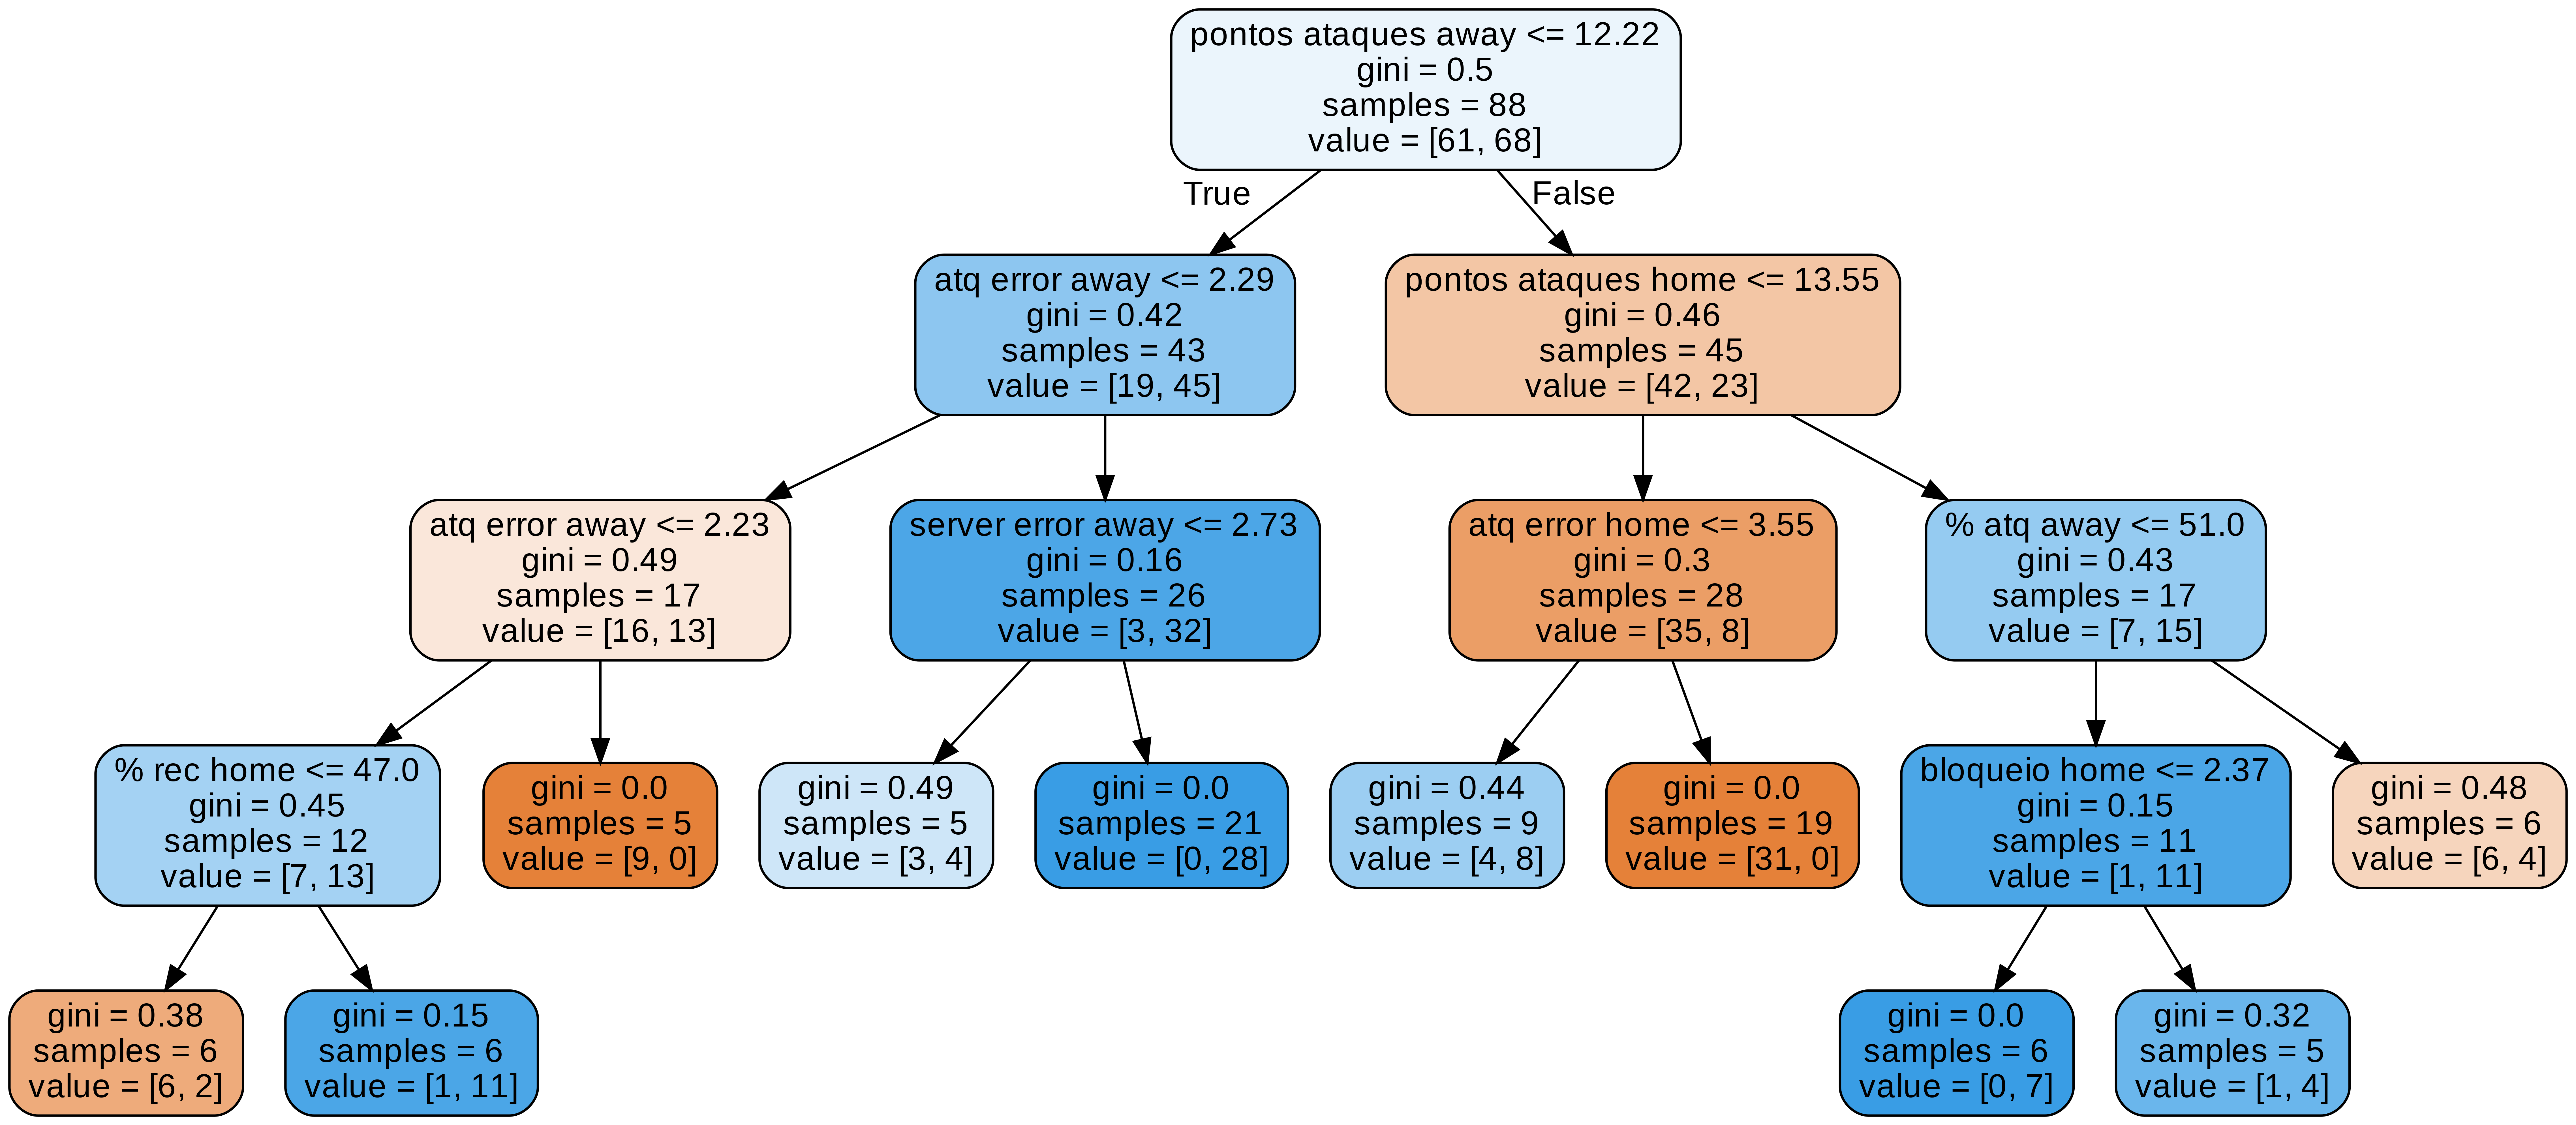

In [40]:
from subprocess import call
from IPython.display import Image
call(['dot','-Tpng','tree.dot','-o','tree.png','-Gdpi=600'])
Image(filename='tree.png')

In [41]:
df_merged.head()
df_splitted_away = df_merged[['team away','total atq away','pontos ataques away','atq error away','% atq away','% rec away','bloqueio away','server error away']]
cols = ['team', 'total atq', 'pontos ataque', 'atq error', '% atq', '% rec', 'bloqueio', 'server error']
df_splitted_away.columns = cols
df_splitted2 = df_merged[['team home','total atq home','pontos ataques home','atq error home','% atq home','% rec home','bloqueio home','server error home']]
df_splitted2.columns = cols
df_splitted2.shape

(185, 8)

In [42]:
df_splitted_away.shape

(185, 8)

In [69]:
df_sla['total atq home'] = df_sla['total atq home'] / df_sla['qtd sets']
df_sla['pontos ataques home'] = df_sla['pontos ataques home'] / df_sla['qtd sets']
df_sla['atq error home'] = df_sla['atq error home'] / df_sla['qtd sets']
df_sla['bloqueio home'] = df_sla['bloqueio home'] / df_sla['qtd sets']
df_sla['server error home'] = df_sla['server error home'] / df_sla['qtd sets']
df_sla['total atq away'] = df_sla['total atq away'] / df_sla['qtd sets']
df_sla['pontos ataques away'] = df_sla['pontos ataques away'] / df_sla['qtd sets']
df_sla['atq error away'] = df_sla['atq error away'] / df_sla['qtd sets']
df_sla['bloqueio away'] = df_sla['bloqueio away'] / df_sla['qtd sets']
df_sla['server error away'] = df_sla['server error away'] / df_sla['qtd sets']


df_vnl['total atq home'] = df_vnl['total atq home'] / df_vnl['qtd sets']
df_vnl['pontos ataques home'] = df_vnl['pontos ataques home'] / df_vnl['qtd sets']
df_vnl['atq error home'] = df_vnl['atq error home'] / df_vnl['qtd sets']
df_vnl['bloqueio home'] = df_vnl['bloqueio home'] / df_vnl['qtd sets']
df_vnl['server error home'] = df_vnl['server error home'] / df_vnl['qtd sets']
df_vnl['total atq away'] = df_vnl['total atq away'] / df_vnl['qtd sets']
df_vnl['pontos ataques away'] = df_vnl['pontos ataques away'] / df_vnl['qtd sets']
df_vnl['atq error away'] = df_vnl['atq error away'] / df_vnl['qtd sets']
df_vnl['bloqueio away'] = df_vnl['bloqueio away'] / df_vnl['qtd sets']
df_vnl['server error away'] = df_vnl['server error away'] / df_vnl['qtd sets']

In [70]:
cols = ['team', 'total atq', 'pontos ataque', 'atq error', '% atq', '% rec', 'bloqueio', 'server error']
df_sla_final_away = df_sla[['team away','total atq away','pontos ataques away','atq error away','% atq away','% rec away','bloqueio away','server error away']]
df_sla_final_away.columns = cols
df_sla_final_home = df_sla[['team home','total atq home','pontos ataques home','atq error home','% atq home','% rec home','bloqueio home','server error home']]
df_sla_final_home.columns = cols

df_vnl_final_away = df_vnl[['team away','total atq away','pontos ataques away','atq error away','% atq away','% rec away','bloqueio away','server error away']]
df_vnl_final_away.columns = cols
df_vnl_final_home = df_vnl[['team home','total atq home','pontos ataques home','atq error home','% atq home','% rec home','bloqueio home','server error home']]
df_vnl_final_home.columns = cols

df_vnl_final_home

,team,total atq,pontos ataque,atq error,% atq,% rec,bloqueio,server error
id_jogo,,,,,,,,
11700,France,25.666667,13.00,2.666667,51,44,2.333333,6.333333
11701,Germany,23.333333,14.00,2.000000,60,35,1.666667,6.333333
11702,Japan,31.333333,15.00,4.333333,48,50,2.333333,2.333333
11703,Serbia,30.250000,16.50,4.750000,55,33,3.500000,4.750000
11704,Netherlands,22.250000,12.25,3.500000,55,20,1.500000,4.500000
...,...,...,...,...,...,...,...,...
11815,France,24.400000,11.40,4.800000,47,43,2.200000,4.000000
11816,Iran,27.750000,14.75,5.250000,53,30,2.250000,4.750000
11817,Slovenia,21.666667,12.00,4.000000,55,29,1.666667,3.000000


In [71]:
superligaa_teams = df_sla_final_home.team.unique()
pallavolo_teams = df_pallavolo.team.unique()
vnl_teams = df_vnl_final_home.team.unique()

In [81]:
import ipywidgets as widgets
from ipywidgets import interact

a = widgets.Dropdown(
    options=superligaa_teams,  
    description='Home:',
    disabled=False,
)

b = widgets.Dropdown(
    options=superligaa_teams,    
    description='Away:',
    disabled=False,
)

c = widgets.Dropdown(
    options=pallavolo_teams,  
    description='Home:',
    disabled=False,
)

d = widgets.Dropdown(
    options=pallavolo_teams,    
    description='Away:',
    disabled=False,
)

e = widgets.Dropdown(
    options=vnl_teams,  
    description='Home:',
    disabled=False,
)

f = widgets.Dropdown(
    options=vnl_teams,    
    description='Away:',
    disabled=False,
)



In [83]:
def resultPredictSuperLigaA(a,b):
  home = df_sla_final_home.loc[df_sla_final_home['team'] == a]
  away = df_sla_final_away.loc[df_sla_final_away['team'] == b]

  home_medias = [round(home['total atq'].mean()),round(home['pontos ataque'].mean()),round(home['atq error'].mean()),round(home['% atq'].mean()),round(home['% rec'].mean()),round(home['bloqueio'].mean()),round(home['server error'].mean())]
  away_medias = [round(away['total atq'].mean()),round(away['pontos ataque'].mean()),round(away['atq error'].mean()),round(away['% atq'].mean()),round(away['% rec'].mean()),round(away['bloqueio'].mean()),round(away['server error'].mean())]
  
  resultado =  home_medias + away_medias
  resultado_final = np.array(resultado)

  resultado_chance = model.predict_proba(resultado_final.reshape(1,-1))
  resultado_home_porcetagem = round(resultado_chance[0][1] * 100, 2)
  resultado_away_porcetagem =  round(resultado_chance[0][0] * 100, 2)
  print('Chances do time',home['team'].iloc[0] ,'vencer:',str(resultado_home_porcetagem)+'%\n'+'Chances do time',away['team'].iloc[0] ,'vencer:',str(resultado_away_porcetagem)+'%')


def resultPredictPalla(c,d):
  home = df_pallavolo.loc[df_pallavolo['team'] == c]
  away = df_pallavolo.loc[df_pallavolo['team'] == d]

  home_medias = [round(home['total atq'].mean()),round(home['pontos ataque'].mean()),round(home['atq error'].mean()),round(home['% atq'].mean()),round(home['% rec'].mean()),round(home['bloqueio'].mean()),round(home['server error'].mean())]
  away_medias = [round(away['total atq'].mean()),round(away['pontos ataque'].mean()),round(away['atq error'].mean()),round(away['% atq'].mean()),round(away['% rec'].mean()),round(away['bloqueio'].mean()),round(away['server error'].mean())]
  
  resultado =  home_medias + away_medias
  resultado_final = np.array(resultado)

  resultado_chance = model.predict_proba(resultado_final.reshape(1,-1))
  resultado_home_porcetagem = round(resultado_chance[0][1] * 100, 2)
  resultado_away_porcetagem =  round(resultado_chance[0][0] * 100, 2)
  print('Chances do time',home['team'].iloc[0] ,'vencer:',str(resultado_home_porcetagem)+'%\n'+'Chances do time',away['team'].iloc[0] ,'vencer:',str(resultado_away_porcetagem)+'%')  


def resultPredictVNL(e,f):
  home = df_vnl_final_home.loc[df_vnl_final_home['team'] == e]
  away = df_vnl_final_away.loc[df_vnl_final_away['team'] == f]

  home_medias = [round(home['total atq'].mean()),round(home['pontos ataque'].mean()),round(home['atq error'].mean()),round(home['% atq'].mean()),round(home['% rec'].mean()),round(home['bloqueio'].mean()),round(home['server error'].mean())]
  away_medias = [round(away['total atq'].mean()),round(away['pontos ataque'].mean()),round(away['atq error'].mean()),round(away['% atq'].mean()),round(away['% rec'].mean()),round(away['bloqueio'].mean()),round(away['server error'].mean())]
  
  resultado =  home_medias + away_medias
  resultado_final = np.array(resultado)

  resultado_chance = model.predict_proba(resultado_final.reshape(1,-1))
  resultado_home_porcetagem = round(resultado_chance[0][1] * 100, 2)
  resultado_away_porcetagem =  round(resultado_chance[0][0] * 100, 2)
  print('Chances do time',home['team'].iloc[0] ,'vencer:',str(resultado_home_porcetagem)+'%\n'+'Chances do time',away['team'].iloc[0] ,'vencer:',str(resultado_away_porcetagem)+'%')


In [82]:
interact(resultPredictSuperLigaA,a=superligaa_teams,b=superligaa_teams)

interactive(children=(Dropdown(description='a', options=('MONTES CLAROS AMERICA VOLEI', 'VOLEI FUNVIC NATAL', …

<function __main__.resultPredictSuperLigaA>

In [62]:
interact(resultPredictPalla,c=pallavolo_teams,d=pallavolo_teams)

interactive(children=(Dropdown(description='c', options=('Monza Vero Volley', 'PiacenzaYou', 'Modena', 'Latina…

<function __main__.resultPredictPalla>

In [84]:
interact(resultPredictVNL,e=vnl_teams,f=vnl_teams)

interactive(children=(Dropdown(description='e', options=('France', 'Germany', 'Japan', 'Serbia', 'Netherlands'…

<function __main__.resultPredictVNL>